In [1]:
# Data manipulation and analysis
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP - spaCy
import spacy
from spacy import displacy
from spacy import tokenizer

# Regular expressions
import re

# NLP - NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topic modeling - Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel

# Machine learning - Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)
default_plot_color = "#00bfbf"

In [3]:
data = pd.read_csv("fake_news_data.csv")

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Distribution of Fake vs Factual News')

Text(0.5, 1.0, 'Distribution of Fake vs Factual News')

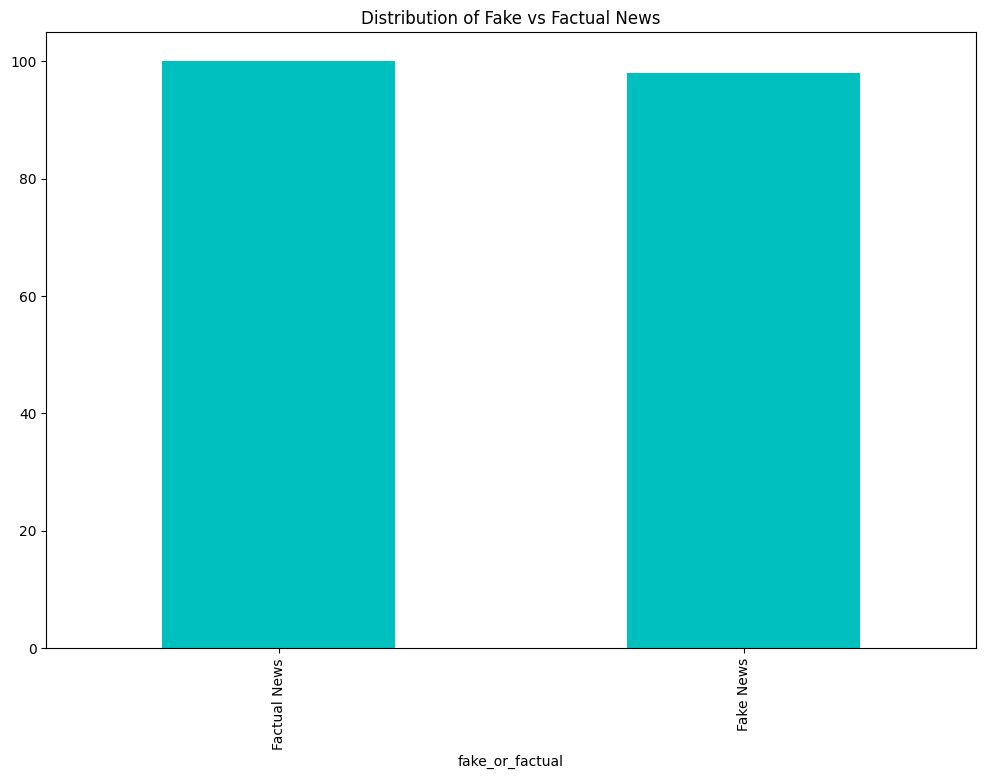

In [6]:
data["fake_or_factual"].value_counts().plot(kind="bar", color=default_plot_color)
plt.title("Distribution of Fake vs Factual News")

### POS Tagging


In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
fake_news = data[data["fake_or_factual"] == "Fake News"]
fact_news = data[data["fake_or_factual"] == "Factual News"]

In [12]:
fake_spacy_docs = list(nlp.pipe(fake_news["text"]))
fact_spacy_docs = list(nlp.pipe(fact_news["text"]))

In [16]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(token.text, token.ent_type_, token.pos_) for token in doc]

In [17]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [19]:
for ix, doc in enumerate(fake_spacy_docs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [20]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [22]:
fact_tagsdf = []

for ix, doc in enumerate(fact_spacy_docs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [23]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [24]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [25]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [27]:
pos_counts_fake = (
    fake_tagsdf.groupby(["token", "pos_tag"])
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)
)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [28]:
pos_counts_fact = (
    fact_tagsdf.groupby(["token", "pos_tag"])
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)
)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [30]:
pos_counts_fake.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(
    10
)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [31]:
pos_counts_fact.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(
    10
)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [32]:
pos_counts_fake[pos_counts_fake["pos_tag"] == "NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [34]:
pos_counts_fact[pos_counts_fact["pos_tag"] == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


In [35]:
pos_counts_fake[pos_counts_fake["pos_tag"] == "VERB"][:15]

,token,pos_tag,counts
6763,s,VERB,147
6774,said,VERB,144
4703,have,VERB,76
5171,know,VERB,54
7534,told,VERB,49
5394,made,VERB,45
4645,had,VERB,43
4565,going,VERB,40
4562,go,VERB,40
6797,say,VERB,34


In [36]:
pos_counts_fact[pos_counts_fact["pos_tag"] == "VERB"][:15]

,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


### Named Entities


In [37]:
top_entities_fake = (
    fake_tagsdf[fake_tagsdf["ner_tag"] != ""]
    .groupby(["token", "ner_tag"])
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)
)

In [38]:
top_entities_fact = (
    fact_tagsdf[fact_tagsdf["ner_tag"] != ""]
    .groupby(["token", "ner_tag"])
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)
)

In [39]:
ner_palette = {
    "ORG": sns.color_palette("Set2").as_hex()[0],
    "GPE": sns.color_palette("Set2").as_hex()[1],
    "NORP": sns.color_palette("Set2").as_hex()[2],
    "PERSON": sns.color_palette("Set2").as_hex()[3],
    "DATE": sns.color_palette("Set2").as_hex()[4],
    "CARDINAL": sns.color_palette("Set2").as_hex()[5],
    "PERCENT": sns.color_palette("Set2").as_hex()[6],
}

[Text(0.5, 1.0, 'Top Named Entities in Fake News Articles')]

[Text(0.5, 1.0, 'Top Named Entities in Fake News Articles')]

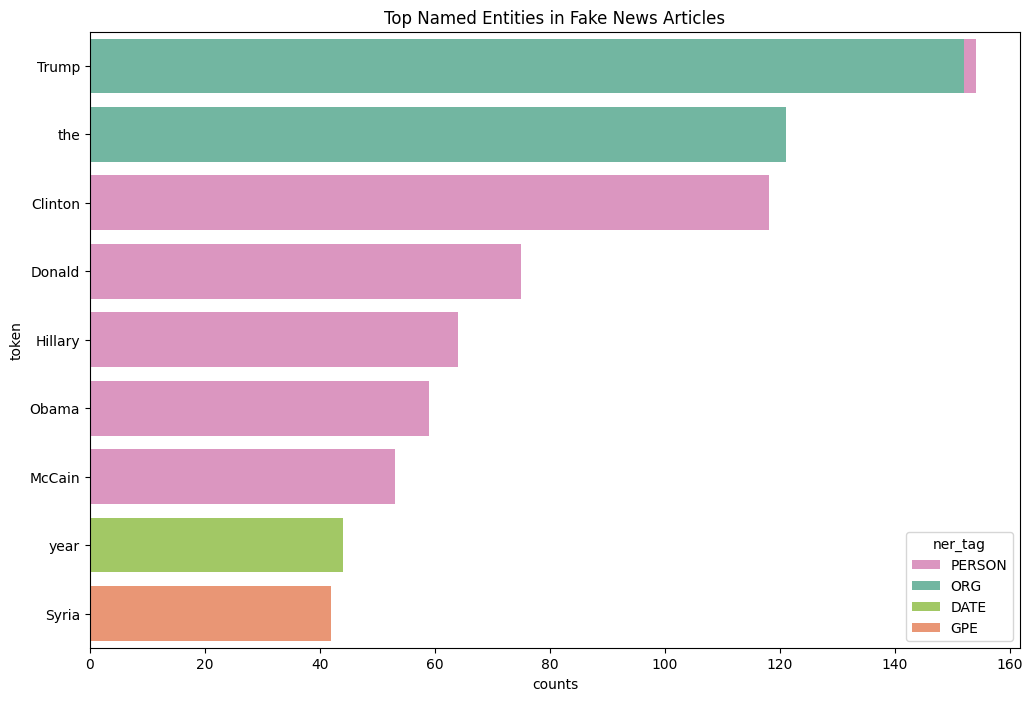

In [41]:
sns.barplot(
    x="counts",
    y="token",
    hue="ner_tag",
    palette=ner_palette,
    data=top_entities_fake[:10],
    orient="h",
    dodge=False,
).set(title="Top Named Entities in Fake News Articles")

[Text(0.5, 1.0, 'Top Named Entities in Fake News Articles')]

[Text(0.5, 1.0, 'Top Named Entities in Fake News Articles')]

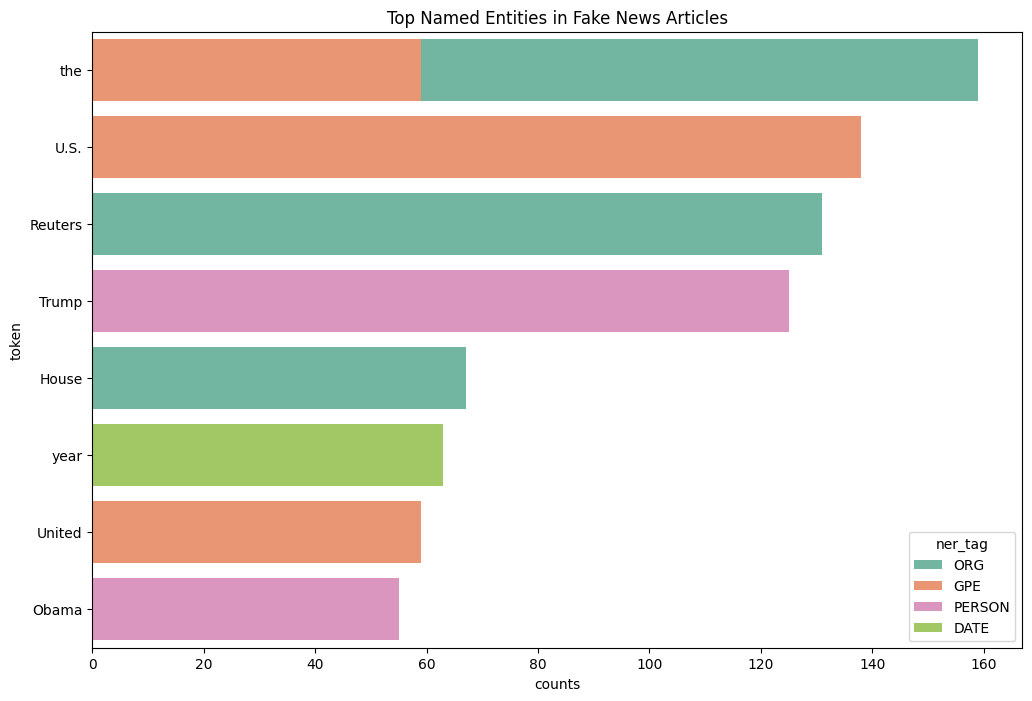

In [42]:
sns.barplot(
    x="counts",
    y="token",
    hue="ner_tag",
    palette=ner_palette,
    data=top_entities_fact[:10],
    orient="h",
    dodge=False,
).set(title="Top Named Entities in Fake News Articles")

### Text Pre-Processing


In [43]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [44]:
data["text_clean"] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x["text"]), axis=1)

In [45]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [46]:
data["text_clean"] = data["text_clean"].str.lower()

In [47]:
data["text_clean"] = data.apply(
    lambda x: re.sub(r"([^\w\s])", "", x["text_clean"]), axis=1
)

In [48]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [49]:
en_stopwords = set(stopwords.words("english"))

In [50]:
data["text_clean"] = data["text_clean"].apply(
    lambda x: " ".join([word for word in x.split() if word not in en_stopwords])
)

In [51]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [52]:
data["text_clean"] = data.apply(lambda x: word_tokenize(x["text_clean"]), axis=1)

In [53]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problems, analogy, susan, jesus, ..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[women, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[us, defense, secretary, jim, mattis, said, mo..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, parties, rapidl..."


In [140]:
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(
    lambda tokens: [lemmatizer.lemmatize(token) for token in tokens]
)

In [ ]:
# Remove numeric and mostly numeric tokens
data["text_clean"] = data["text_clean"].apply(
    lambda tokens: [
        token for token in tokens if not token.isdigit() and not token.isnumeric()
    ]
)

In [142]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_scores,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, percent, country, grossly, under...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [143]:
tokens_clean = sum(data["text_clean"], [])

In [144]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    278
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


[Text(0.5, 1.0, 'Top 10 Unigrams in News Articles')]

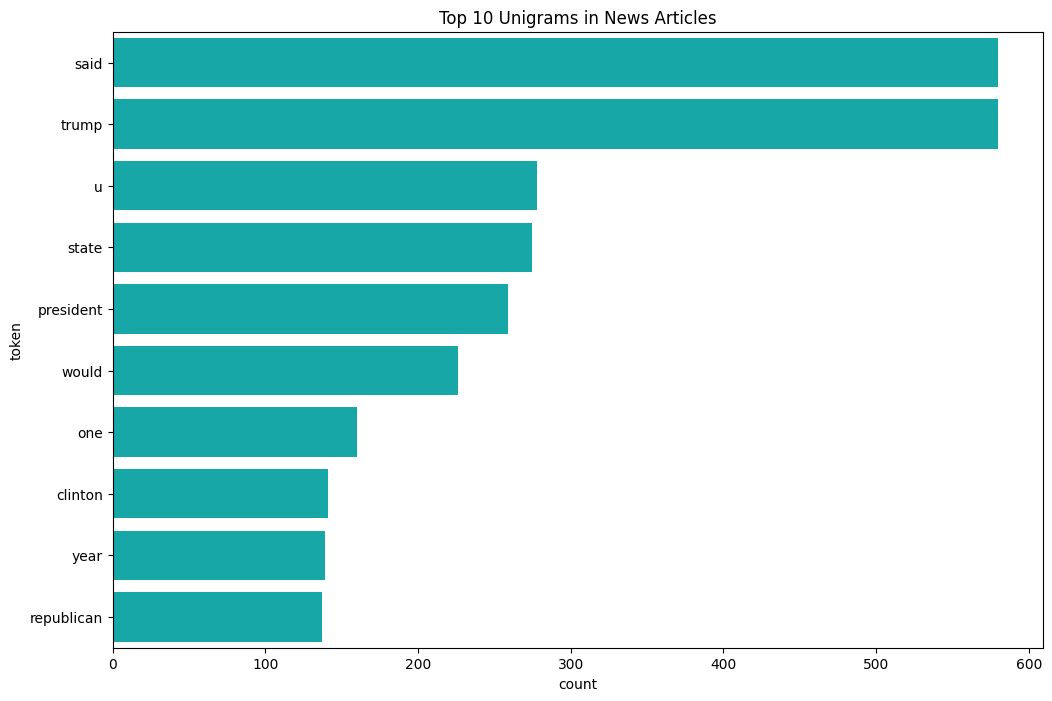

In [145]:
unigrams["token"] = unigrams["index"].apply(lambda x: x[0])
sns.barplot(
    x="count", y="token", data=unigrams, orient="h", color=default_plot_color
).set(title="Top 10 Unigrams in News Articles")

In [146]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


[Text(0.5, 1.0, 'Top 10 Bigrams in News Articles')]

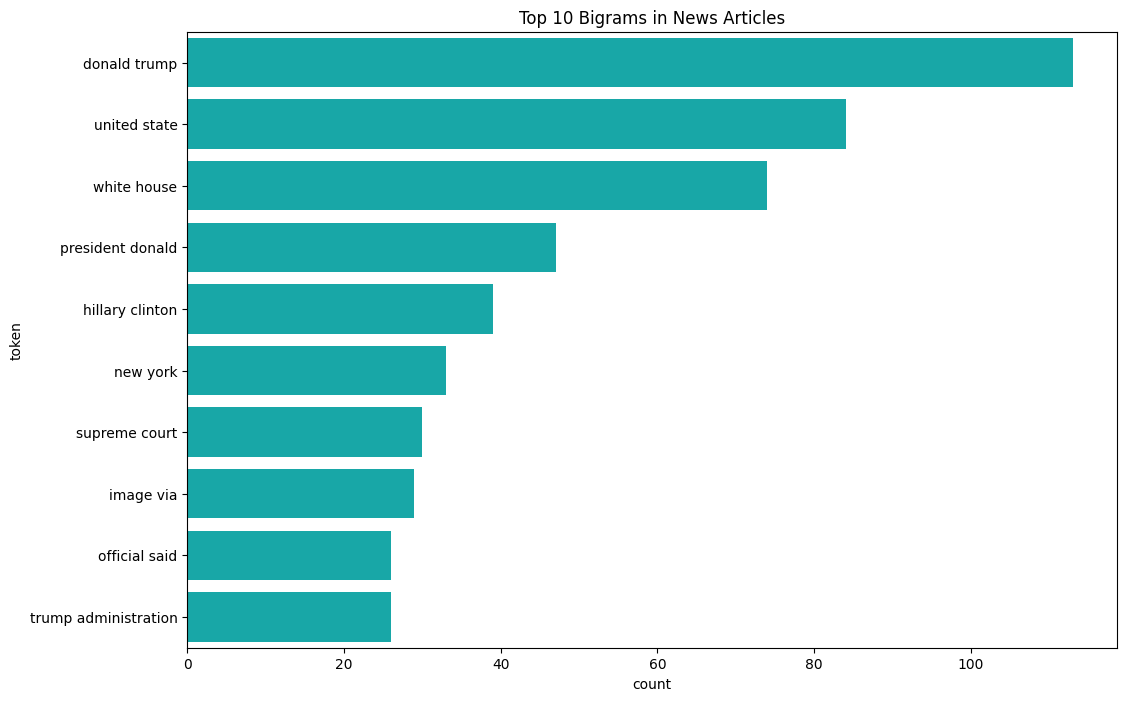

In [147]:
bigrams["token"] = bigrams["index"].apply(lambda x: " ".join(x))
sns.barplot(
    x="count", y="token", data=bigrams, orient="h", color=default_plot_color
).set(title="Top 10 Bigrams in News Articles")

In [148]:
trigrams = (pd.Series(nltk.ngrams(tokens_clean, 3)).value_counts()).reset_index()[:10]
print(trigrams)

                           index  count
0     (president, donald, trump)     46
1     (president, barack, obama)     14
2              (new, york, time)     11
3         (u, president, donald)     10
4           (food, stamp, fraud)     10
5       (white, house, official)     10
6         (fbi, director, james)      8
7       (director, james, comey)      8
8        (high, school, student)      7
9  (national, security, adviser)      7


[Text(0.5, 1.0, 'Top 10 Trigrams in News Articles')]

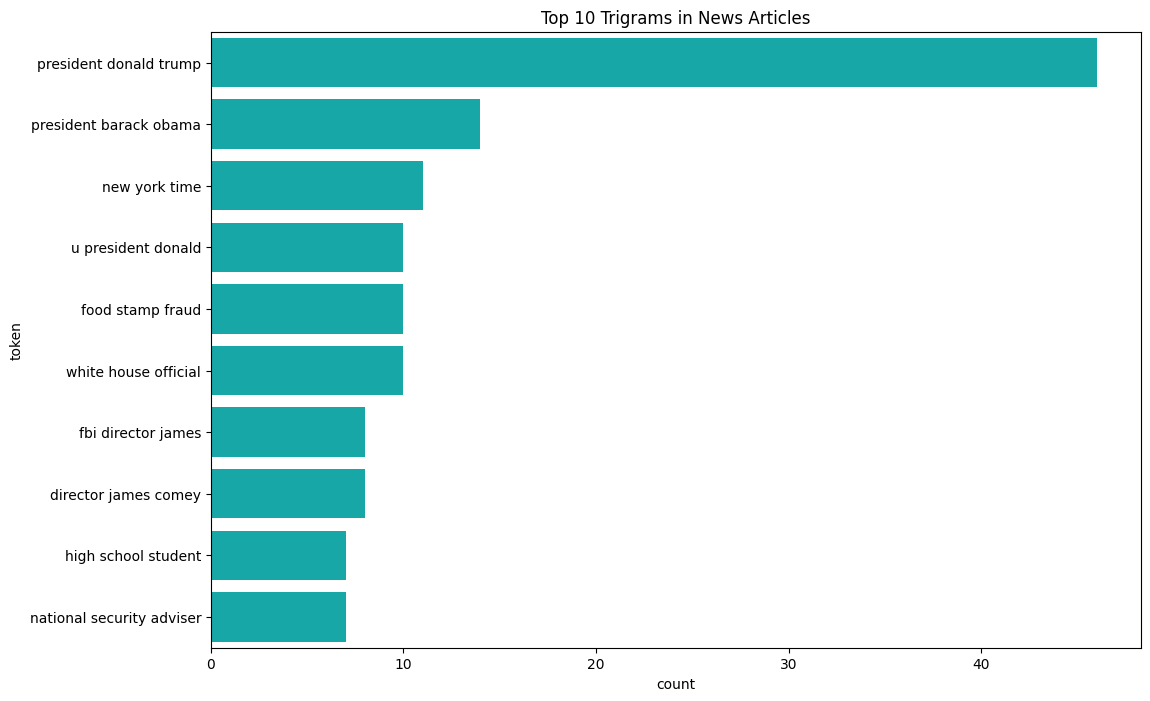

In [149]:
trigrams["token"] = trigrams["index"].apply(lambda x: " ".join(x))
sns.barplot(
    x="count", y="token", data=trigrams, orient="h", color=default_plot_color
).set(title="Top 10 Trigrams in News Articles")

### Sentiment Analysis


In [150]:
vader_sentiment = SentimentIntensityAnalyzer()

In [151]:
data["vader_sentiment_scores"] = data["text"].apply(
    lambda x: vader_sentiment.polarity_scores(x)["compound"]
)

In [152]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_scores,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, percent, country, grossly, under...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [153]:
bins = [-1.0, -0.01, 0.01, 1.0]
names = ["negative", "neutral", "positive"]

In [154]:
data["vader_sentiment_label"] = pd.cut(
    data["vader_sentiment_scores"], bins, labels=names
)

In [155]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_scores,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, percent, country, grossly, under...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


Text(0.5, 1.0, 'Distribution of VADER Sentiment Labels')

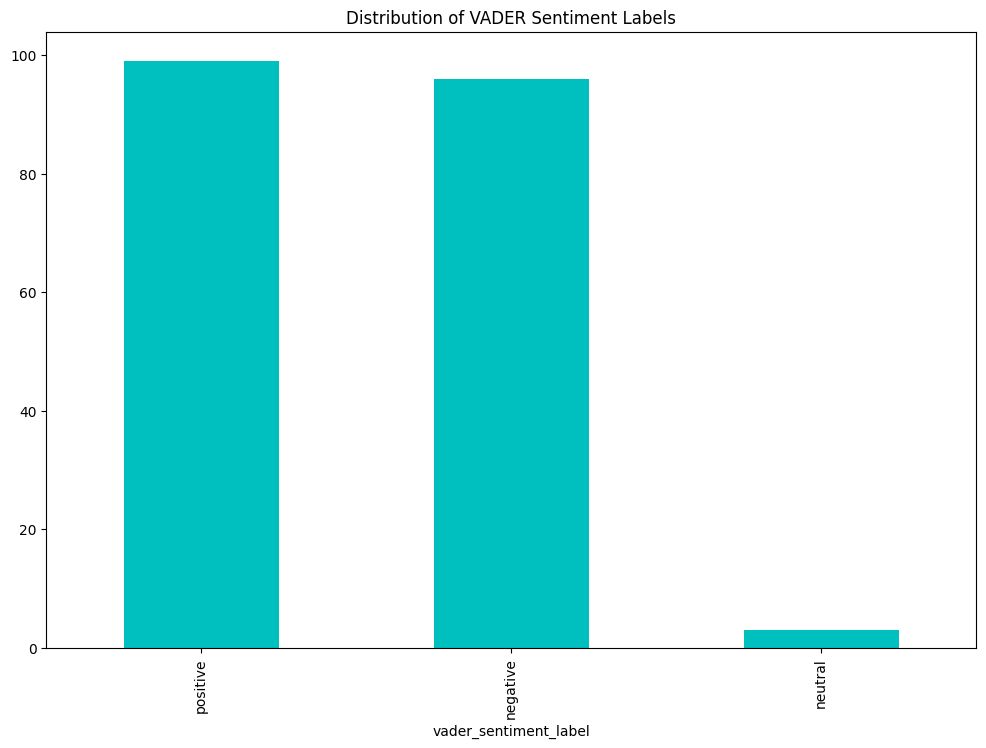

In [156]:
data["vader_sentiment_label"].value_counts().plot(kind="bar", color=default_plot_color)
plt.title("Distribution of VADER Sentiment Labels")

/var/folders/0x/7sbtn28900ndzns673ksz6ww0000gn/T/ipykernel_18481/2479444007.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'VADER Sentiment by Fake vs Factual News')]

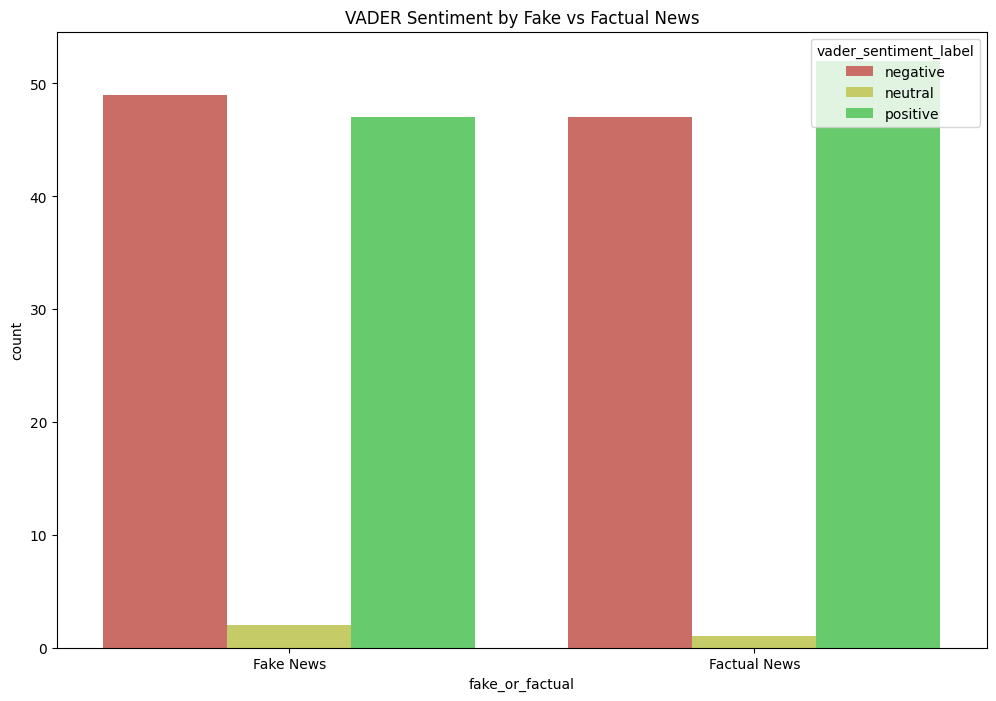

In [157]:
sns.countplot(
    x="fake_or_factual",
    hue="vader_sentiment_label",
    data=data,
    palette=sns.color_palette("hls"),
).set(title="VADER Sentiment by Fake vs Factual News")

### Topic Modelling


In [158]:
fake_news_text = data[data["fake_or_factual"] == "Fake News"]["text_clean"].reset_index(
    drop=True
)

In [159]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [160]:
doc_term_fake = [dictionary_fake.doc2bow(doc) for doc in fake_news_text]

In [161]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(
        corpus=doc_term_fake,
        id2word=dictionary_fake,
        num_topics=num_topics,
        random_state=42,
    )
    model_list.append(model)
    coherencemodel = CoherenceModel(
        model=model,
        texts=fake_news_text,
        dictionary=dictionary_fake,
        coherence="c_v",
    )
    coherence_values.append(coherencemodel.get_coherence())

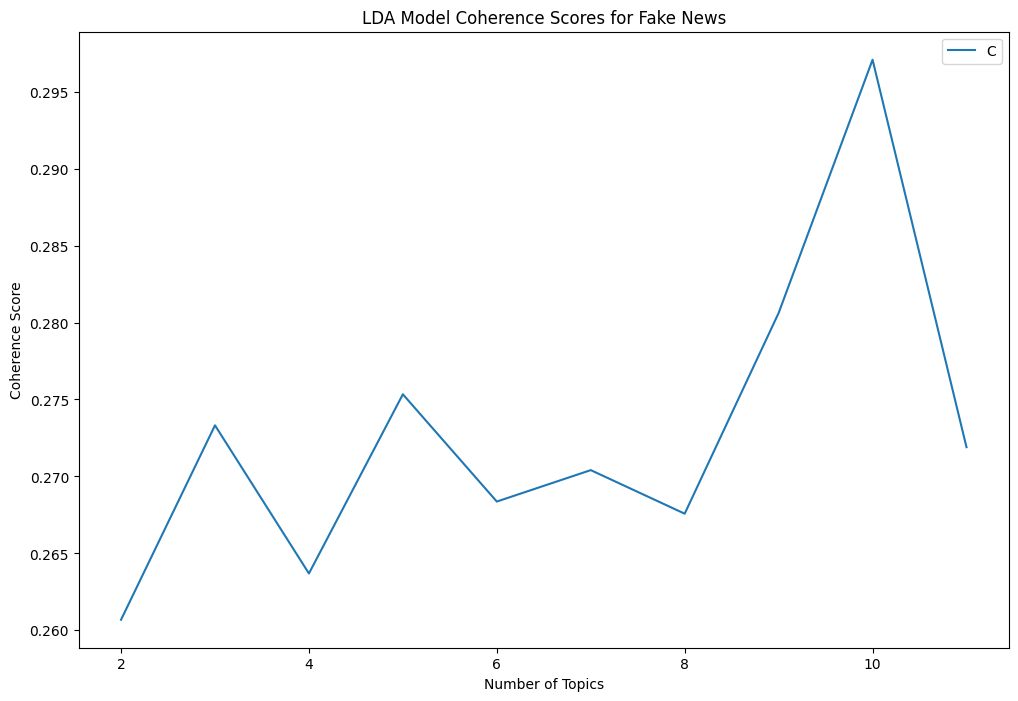

In [162]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Score"), loc="best")
plt.title("LDA Model Coherence Scores for Fake News")
plt.show()

In [163]:
num_topics = 10
lda_model = gensim.models.LdaModel(
    corpus=doc_term_fake,
    id2word=dictionary_fake,
    num_topics=num_topics,
    random_state=42,
)

In [164]:
lda_model.print_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.010*"trump" + 0.006*"one" + 0.005*"clinton" + 0.004*"president" + 0.004*"two" + 0.004*"said" + 0.004*"year" + 0.004*"u" + 0.004*"donald" + 0.003*"state"'),
 (1,
  '0.014*"trump" + 0.007*"clinton" + 0.005*"said" + 0.004*"would" + 0.004*"woman" + 0.003*"president" + 0.003*"hillary" + 0.003*"u" + 0.003*"donald" + 0.003*"state"'),
 (2,
  '0.013*"trump" + 0.005*"email" + 0.005*"said" + 0.004*"clinton" + 0.004*"state" + 0.004*"student" + 0.004*"president" + 0.004*"news" + 0.004*"time" + 0.003*"official"'),
 (3,
  '0.007*"said" + 0.005*"state" + 0.004*"time" + 0.004*"school" + 0.003*"u" + 0.003*"trump" + 0.003*"would" + 0.003*"lerner" + 0.003*"million" + 0.003*"mccain"'),
 (4,
  '0.007*"president" + 0.006*"said" + 0.005*"trump" + 0.005*"u" + 0.004*"year" + 0.004*"state" + 0.004*"clinton" + 0.004*"obama" + 0.003*"people" + 0.003*"day"'),
 (5,
  '0.009*"trump" + 0.007*"state" + 0.005*"clinton" + 0.005*"u" + 0.004*"one" + 0.004*"said" + 0.003*"president" + 0.003*"would" + 0.003*"time" 

In [165]:
def tfid_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [166]:
def get_coherence_scores(corpus, dictionary, min_topics, max_topics):
    coherence_values = []
    model_list = []

    for num_topics in range(min_topics, max_topics + 1):
        model = gensim.models.LsiModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_seed=42,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=fake_news_text,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_values.append(coherencemodel.get_coherence())

    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("Coherence Score"), loc="best")
    plt.title("LSI Model Coherence Scores for Fake News")
    plt.show()

In [167]:
corpus_tfidf = tfid_corpus(doc_term_fake)

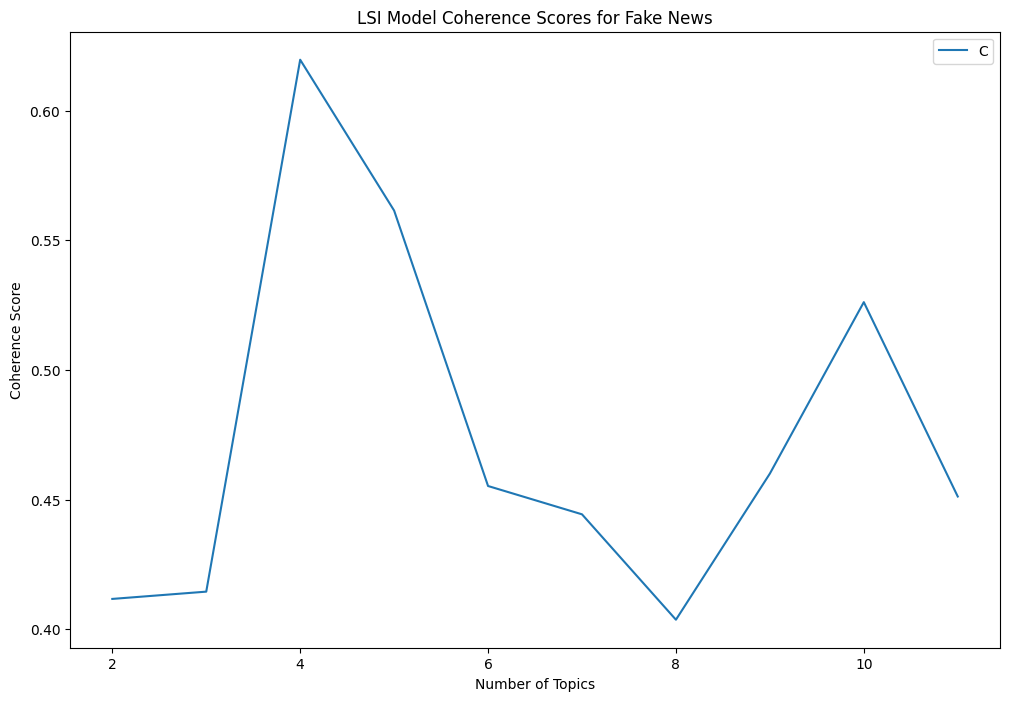

In [168]:
get_coherence_scores(
    corpus=corpus_tfidf,
    dictionary=dictionary_fake,
    min_topics=2,
    max_topics=11,
)

In [169]:
lsa_model = gensim.models.LsiModel(
    corpus=corpus_tfidf,
    id2word=dictionary_fake,
    num_topics=4,
    random_seed=42,
)

In [170]:
lsa_model.print_topics()

[(0,
  '0.192*"trump" + 0.137*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.090*"president" + 0.089*"woman" + 0.078*"republican" + 0.078*"flynn" + 0.077*"party" + 0.075*"candidate"'),
 (1,
  '0.329*"boiler" + 0.287*"acr" + 0.247*"room" + 0.243*"pm" + 0.188*"broadcast" + 0.182*"radio" + 0.144*"animal" + 0.144*"tune" + 0.136*"jay" + 0.134*"episode"'),
 (2,
  '0.638*"flynn" + 0.185*"immunity" + 0.127*"nana" + 0.119*"mr" + 0.111*"march" + 0.099*"source" + 0.098*"russian" + 0.093*"adviser" + 0.089*"russia" + -0.088*"school"'),
 (3,
  '-0.220*"clinton" + 0.185*"school" + 0.176*"student" + -0.142*"hillary" + 0.118*"county" + -0.113*"sander" + 0.108*"flynn" + -0.099*"woman" + -0.097*"debate" + -0.090*"nominee"')]

### Clasification model


In [171]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_scores,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, percent, country, grossly, under...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [172]:
X = [",".join(map(str, l)) for l in data["text_clean"]]

In [187]:
Y = data["fake_or_factual"]

In [174]:
countvec = CountVectorizer()

In [175]:
countvec_fit = countvec.fit_transform(X)

In [176]:
bagOfWords = pd.DataFrame(
    countvec_fit.toarray(), columns=countvec.get_feature_names_out()
)
bagOfWords

,100seat,102please,104please,10th,10year,115th,116yearold,122224clinton,123622bclinton,12minute,12yearold,13seat,14point,14yearold,15anhour,16th,16yearold,18kai,1970sclinton,1973via,1990s,1990sera,1st,1trillion,2000mile,2000s,2011watch,2014lerner,2016a,2016antitrump,2016either,2016holy,2016in,2016melania,2016on,2016protesters,2016ronpaul,2016so,2016that,2016the,...,yi,yiannopoulos,yik,yikes,yoav,york,youll,young,younger,youputin,youre,youtube,youtubead3media,youtubewikimedia,youve,ypsilanti,yu,yyc,zachary,zafer,zaidi,zarrab,zaru,zayed,zdf,zehlif,zeina,zephyr,zero,zimbabwe,zimbabwean,zimdars,zimmerman,zina,zionism,zoe,zone,zoom,zouka,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [177]:
X_train, X_test, Y_train, Y_test = train_test_split(
    bagOfWords, Y, test_size=0.3, random_state=42
)

In [178]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, Y_train)

LogisticRegression(random_state=42)

In [179]:
y_pred_lr = lr.predict(X_test)

In [180]:
accuracy_score(Y_test, y_pred_lr)

0.8666666666666667

In [181]:
print(classification_report(Y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.88      0.88      0.88        32
   Fake News       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [182]:
svm = SGDClassifier(random_state=42)
svm.fit(X_train, Y_train)

SGDClassifier(random_state=42)

In [183]:
y_pred_svm = svm.predict(X_test)

In [184]:
accuracy_score(Y_test, y_pred_svm)

0.8333333333333334

In [185]:
print(classification_report(Y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.82      0.88      0.85        32
   Fake News       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

